# Lab 7: S-LDSC

## Introduction

In this exercise, you will use stratified LD score regression (S-LDSC) to partition heritability for GWAS phenotypes from UK Biobank.

Below is a step by step guide on setting up and running the analysis. 


## Installing LDSC

We start by installing LDSC. Detailed instructions can be found [here](https://github.com/bulik/ldsc).

* In our lab7 folder, we have the ldsc directory, which was downloaded from [here](https://github.com/bulik/ldsc). Before analyzing the data, we need to set up the environment for running LDSC. The specific steps are as follows:

In [1]:

conda env create --file ldsc/environment.yml # To set up the environment required for running LDSC in the system-level Bash environment

conda activate ldsc

python ldsc/ldsc.py -h
python ldsc/munge_sumstats.py -h



CondaValueError: prefix already exists: /home/wangchao/miniconda3/envs/ldsc

usage: ldsc.py [-h] [--out OUT] [--bfile BFILE] [--l2] [--extract EXTRACT]
               [--keep KEEP] [--ld-wind-snps LD_WIND_SNPS]
               [--ld-wind-kb LD_WIND_KB] [--ld-wind-cm LD_WIND_CM]
               [--print-snps PRINT_SNPS] [--annot ANNOT] [--thin-annot]
               [--cts-bin CTS_BIN] [--cts-breaks CTS_BREAKS]
               [--cts-names CTS_NAMES] [--per-allele] [--pq-exp PQ_EXP]
               [--no-print-annot] [--maf MAF] [--h2 H2] [--h2-cts H2_CTS]
               [--rg RG] [--ref-ld REF_LD] [--ref-ld-chr REF_LD_CHR]
               [--w-ld W_LD] [--w-ld-chr W_LD_CHR] [--overlap-annot]
               [--print-coefficients] [--frqfile FRQFILE]
               [--frqfile-chr FRQFILE_CHR] [--no-intercept]
               [--intercept-h2 INTERCEPT_H2]
               [--intercept-gencov INTERCEPT_GENCOV] [--M M]
               [--two-step TWO_STEP] [--chisq-max CHISQ_MAX]
               [--r

                        prevents LDSC from displaying output that is
                        meaningless with overlapping categories.
  --print-coefficients  when categories are overlapping, print coefficients as
                        well as heritabilities.
  --frqfile FRQFILE     For use with --overlap-annot. Provides allele
                        frequencies to prune to common snps if --not-M-5-50 is
                        not set.
  --frqfile-chr FRQFILE_CHR
                        Prefix for --frqfile files split over chromosome.
  --no-intercept        If used with --h2, this constrains the LD Score
                        regression intercept to equal 1. If used with --rg,
                        this constrains the LD Score regression intercepts for
                        the h2 estimates to be one and the intercept for the
                        genetic covariance estimate to be zero.
  --intercept-h2 INTERCEPT_H2
                        Intercepts for constrained-interc

  --nstudy NSTUDY       Name of NSTUDY column (if not a name that ldsc
                        understands). NB: case insensitive.
  --nstudy-min NSTUDY_MIN
                        Minimum # of studies. Default is to remove everything
                        below the max, unless there is an N column, in which
                        case do nothing.
  --ignore IGNORE       Comma-separated list of column names to ignore.
  --a1-inc              A1 is the increasing allele.
  --keep-maf            Keep the MAF column (if one exists).


* If these commands fail with an error, then something has gone wrong during the installation process.


## Format summary statistics

Before running analysis with LDSC, we need to first reformat input summary statistics. This step is sometimes called munging.

In [3]:
mkdir -p output

# make sure you use the right paths; I don't know beforehand where you might have installed the ldsc software
python ldsc/munge_sumstats.py \
--sumstats GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq.txt \
--merge-alleles w_hm3.snplist \
--chunksize 50000 \
--out ./output/BMI \
--a1-inc


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./munge_sumstats.py \
--out ./output/BMI \
--merge-alleles w_hm3.snplist \
--a1-inc  \
--chunksize 50000 \
--sumstats GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq.txt 

Interpreting column names as follows:
Allele2:	Allele 2, interpreted as non-ref allele for signed sumstat.
MarkerName:	Variant ID (e.g., rs number)
Allele1:	Allele 1, interpreted as ref allele for signed sumstat.
p:	p-Value
N:	Sample size

Reading list of SNPs for allele merge from w_hm3.snplist
Read 1217311 SNPs for allele merge.
Reading sumstats from GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq.txt into memory 50000 SNPs at a time.
...........................

## Partition heritability

S-LDSC partition heritability into different annotation categories by fitting the following model:

$$\Large E \left [X_{j}^{2} \right] = \Large N \sum_{C}\tau_{C} \ell(j,C) + Na + 1 \tag{1}$$

Here, $N$ is the sample size; $C$ indexes annotation categories; $\ell(j,C)$ is the LD score of SNP $j$ with respect to category $C$, defined as $\ell(j,C) = \sum_{k \in C} r_{jk}^2$; $a$ is a term that measures the contribution of confounding biases; $\tau_{C}$ represents the per-SNP contribution to heritability of category $C$.

Unlike the original LDSC, where ld score is calculated using all the SNPs and the regression has a single predictor, in stratified LDSC we regress against ld scores from multiple categories and that helps us estimate the contribution to heritability from each category.

S-LDSC is implemented as part of the `ldsc` software. To run S-LDSC, we need to provide the following infomation through command line arguments:

* **--w-ld-chr**: the sum of LD scores over all input SNPs (i.e., the SNPs for which you have Z-scores). The total LD scores are just used for weighting the regression (hence the "w") and generally do not have a huge impact on the results.

* **--ref-ld-chr**: a list of LD scores, one for each annotation category. The developers of S-LDSC also provide a baseline model that contains 53 (overlapping) functional categories.

* **--frqfile-chr**: allele frequency information. `ldsc` only uses SNPs with MAF > 5%.

* **--overlap-annot**: a flag that tells `ldsc` the input annotation categories overlap with each other.

In [5]:
# make sure you use the right paths; I don't know beforehand where you might have installed the ldsc software

python ldsc/ldsc.py \
    --h2 BMI.sumstats.gz \
    --ref-ld-chr baseline/baseline. \
    --w-ld-chr weights_hm3_no_hla/weights. \
    --overlap-annot \
    --frqfile-chr 1000G_frq/1000G.mac5eur. \
    --out ./output/BMI_baseline


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BMI.sumstats.gz \
--ref-ld-chr baseline/baseline. \
--out ./output/BMI_baseline \
--overlap-annot  \
--frqfile-chr 1000G_frq/1000G.mac5eur. \
--w-ld-chr weights_hm3_no_hla/weights. 

Beginning analysis at Mon Jun 17 10:53:32 2024
Reading summary statistics from BMI.sumstats.gz ...
Read summary statistics for 1040803 SNPs.
Reading reference panel LD Score from baseline/baseline.[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1189907 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from weights_hm3_no_hla/weights.[1-22] ... (ldscore_fromlist)
Read regression weight L

## Visualize the partitioned heritability

We can use the following code to visualize the results. **Move BMI_baseline.results to your local machine and run the following R code.**

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

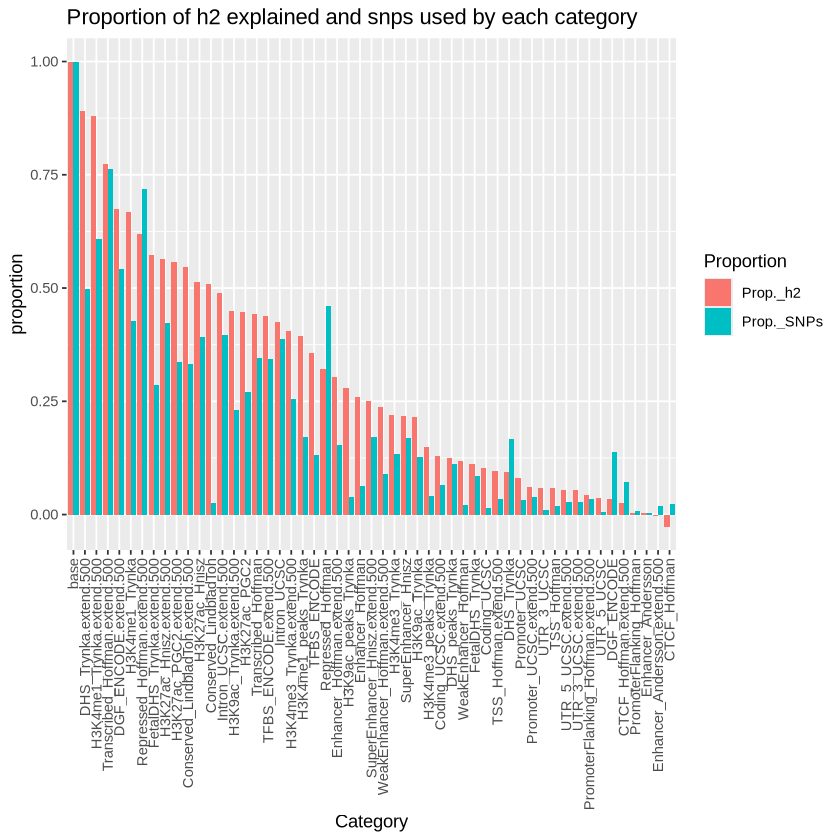

Category,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
base_0,1.000000000,1.000000000,0.00000000,1.0000000,0.00000000,NA
Coding_UCSC_0,0.014658156,0.103648776,0.02652197,7.0710650,1.80936595,1.109653e-03
Coding_UCSC.extend.500_0,0.064555416,0.128576220,0.03234980,1.9917186,0.50111668,5.066399e-02
Conserved_LindbladToh_0,0.026062507,0.508333023,0.05887581,19.5043796,2.25902332,1.334258e-15
Conserved_LindbladToh.extend.500_0,0.332514033,0.545464775,0.06812064,1.6404263,0.20486545,1.494690e-03
CTCF_Hoffman_0,0.023828848,-0.027033602,0.04875659,-1.1344905,2.04611608,2.892460e-01
CTCF_Hoffman.extend.500_0,0.071062184,0.025405743,0.04571416,0.3575142,0.64329798,3.224219e-01
DGF_ENCODE_0,0.137593608,0.034288392,0.12347936,0.2492005,0.89742078,4.048388e-01
DGF_ENCODE.extend.500_0,0.541500875,0.673575439,0.06782953,1.2439046,0.12526210,5.044787e-02


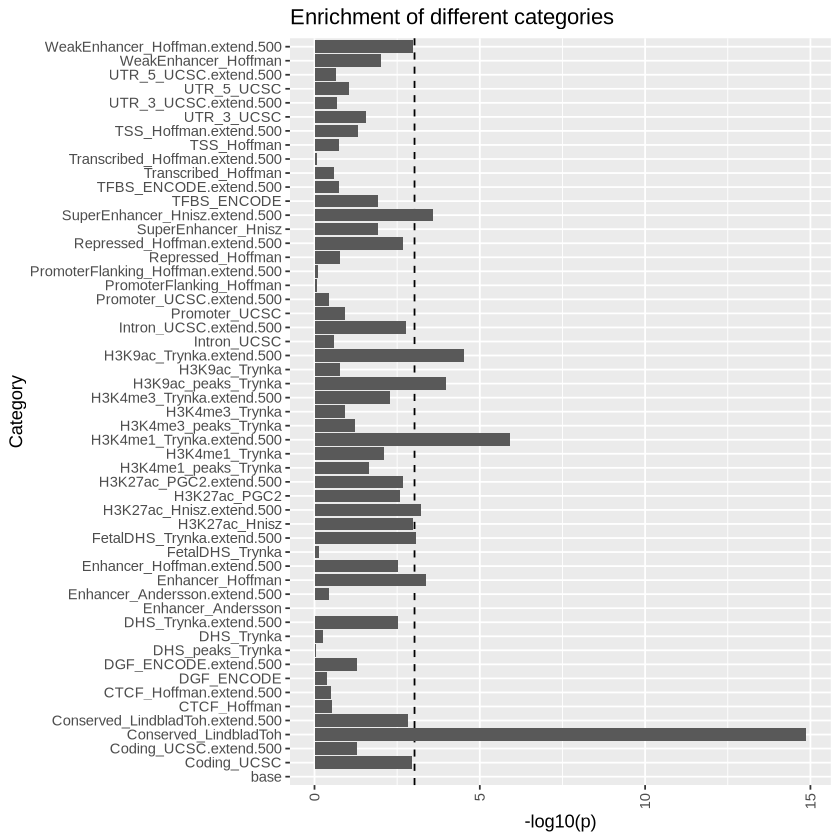

In [4]:
library(data.table)
library(tidyverse)

dir <- "output"  # specify your own directory

h2 <- paste0(dir, '/BMI_baseline.results')

h2 <- fread(h2)

# barplot
h2 %>% arrange(desc(Prop._h2)) %>% 
  mutate(Category = str_remove(Category, "_0")) %>% 
  mutate(Category = factor(Category, level = Category)) %>% 
  pivot_longer(.,cols = c(Prop._SNPs,Prop._h2),names_to = "Proportion") %>% 
  ggplot(., aes(x=Category, y=value)) + 
  geom_bar(aes(fill = Proportion),stat = "identity",position = "dodge") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ggtitle("Proportion of h2 explained and snps used by each category") +
  ylab("proportion") + xlab("Category")

# enrichment plot
h2 %>% mutate(Category = str_remove(Category, "_0")) %>% 
  ggplot(., aes(x=Category, y=-log10(Enrichment_p))) +
  geom_hline(yintercept=-log10(0.05/nrow(h2)),linetype=2) +
  geom_bar(stat = "identity",position = "dodge") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  ggtitle("Enrichment of different categories") +
  ylab("-log10(p)") + xlab("Category") +
  coord_flip() 

h2


The dotted line shows the Bonferonni significance at $\alpha$ cut off of 0.05.

## Estimating proportion of heritability by cell-type group

Now we run a cell type specific analysis to prioritize relevant cell types and estimate proportion of heritability attribute to different cell types. We will run three cell type groups: CNS, Skeletal Muscle, and Immune.

In [8]:
# CNS
python ldsc/ldsc.py \
    --h2 BMI.sumstats.gz \
    --ref-ld-chr cell_type_groups/CNS.,baseline/baseline. \
    --w-ld-chr weights_hm3_no_hla/weights. \
    --overlap-annot \
    --print-coefficients \
    --frqfile-chr 1000G_frq/1000G.mac5eur. \
    --out ./output/BMI_CNS

# Skeletal Muscle
python ldsc/ldsc.py \
    --h2 BMI.sumstats.gz \
    --ref-ld-chr cell_type_groups/SkeletalMuscle.,baseline/baseline. \
    --w-ld-chr weights_hm3_no_hla/weights. \
    --overlap-annot \
    --print-coefficients \
    --frqfile-chr 1000G_frq/1000G.mac5eur. \
    --out ./output/BMI_SkeletalMuscle

# Immune
python ldsc/ldsc.py \
    --h2 BMI.sumstats.gz \
    --ref-ld-chr cell_type_groups/Immune.,baseline/baseline. \
    --w-ld-chr weights_hm3_no_hla/weights. \
    --overlap-annot \
    --print-coefficients \
    --frqfile-chr 1000G_frq/1000G.mac5eur. \
    --out ./output/BMI_Immune


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BMI.sumstats.gz \
--ref-ld-chr cell_type_groups/CNS.,baseline/baseline. \
--out ./output/BMI_CNS \
--overlap-annot  \
--frqfile-chr 1000G_frq/1000G.mac5eur. \
--w-ld-chr weights_hm3_no_hla/weights. \
--print-coefficients  

Beginning analysis at Mon Jun 17 15:30:14 2024
Reading summary statistics from BMI.sumstats.gz ...
Read summary statistics for 1040803 SNPs.
Reading reference panel LD Score from cell_type_groups/CNS.,baseline/baseline.[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1189907 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from weights_hm3_no_hla

Lambda GC: 1.0375
Mean Chi^2: 1.1104
Intercept: 0.7763 (0.0105)
Ratio < 0 (usually indicates GC correction).
Reading annot matrix from cell_type_groups/Immune.,baseline/baseline.[1-22] ... (annot)
Results printed to ./output/BMI_Immune.results
Analysis finished at Mon Jun 17 15:36:35 2024
Total time elapsed: 2.0m:12.82s


## Visualize h2 estimate by cell type

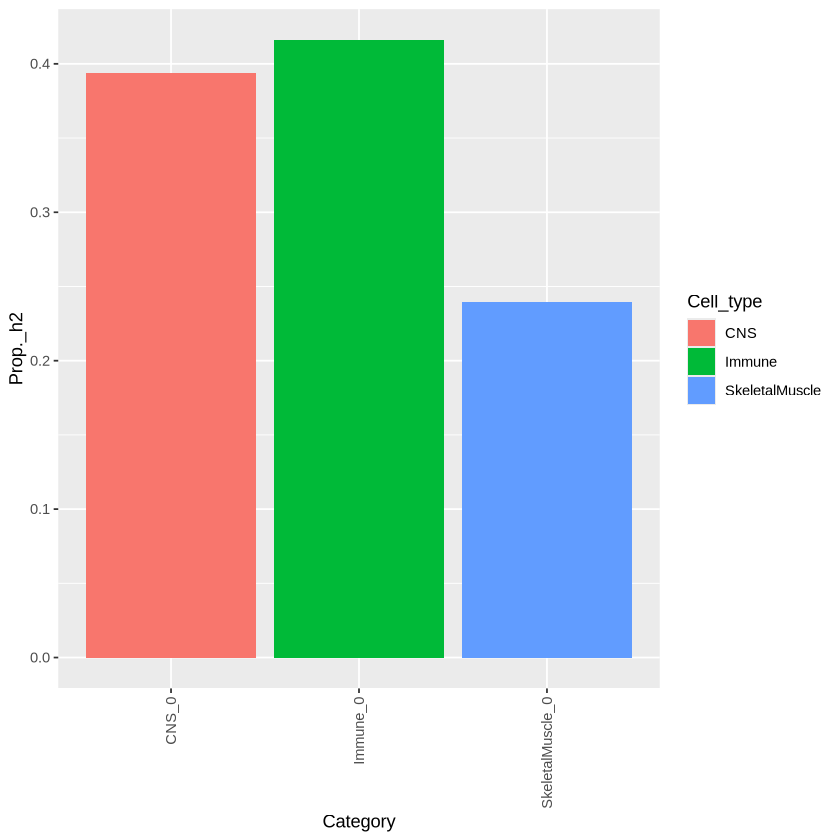

In [9]:
dir <- "output"

cns <- paste0(dir, '/BMI_CNS.results')
ske <- paste0(dir, '/BMI_SkeletalMuscle.results')
immune <- paste0(dir, '/BMI_Immune.results')

cns <- fread(cns)
ske <- fread(ske)
immune <- fread(immune)

cns %>% dplyr::filter(Category == "CNS_0") %>% mutate(Cell_type = "CNS") %>% 
  bind_rows(ske %>% dplyr::filter(Category == "SkeletalMuscle_0") %>% 
              mutate(Cell_type = "SkeletalMuscle")) %>% 
  bind_rows(immune %>% dplyr::filter(Category == "Immune_0") %>% 
              mutate(Cell_type = "Immune")) %>% 
  #mutate(Category = factor(Category, level = Category)) %>% 
  ggplot(., aes(x=Category, y=Prop._h2)) + 
  geom_bar(aes(fill = Cell_type),stat = "identity",position = "dodge") + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


## Cell type-specific analysis

A more efficient way to do cell type-specific analysis is using the `--h2-cts` flag.

In [14]:
# Reference: https://www.jneurosci.org/content/28/1/264
python ldsc/ldsc.py \
  --h2-cts BMI.sumstats.gz \
  --ref-ld-chr 1000G_EUR_Phase3_baseline/baseline. \
  --out ./output/BMI_Cahoy \
  --ref-ld-chr-cts Cahoy.ldcts \
  --w-ld-chr weights_hm3_no_hla/weights.


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2-cts BMI.sumstats.gz \
--ref-ld-chr 1000G_EUR_Phase3_baseline/baseline. \
--out ./output/BMI_Cahoy \
--ref-ld-chr-cts Cahoy.ldcts \
--w-ld-chr weights_hm3_no_hla/weights. 

Beginning analysis at Mon Jun 17 15:47:41 2024
Reading summary statistics from BMI.sumstats.gz ...
Read summary statistics for 1040803 SNPs.
Reading reference panel LD Score from 1000G_EUR_Phase3_baseline/baseline.[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1190321 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from weights_hm3_no_hla/weights.[1-22] ... (ldscore_fromlist)
Read regression we

## Visualize the cell specific analyses results

Name,Coefficient,Coefficient_std_error,Coefficient_P_value
<chr>,<dbl>,<dbl>,<dbl>
Neuron,3.717499e-09,2.995094e-09,0.1072667
Oligodendrocyte,-2.077678e-09,2.564662e-09,0.7910636
Astrocyte,-4.014899e-09,2.491836e-09,0.9464343


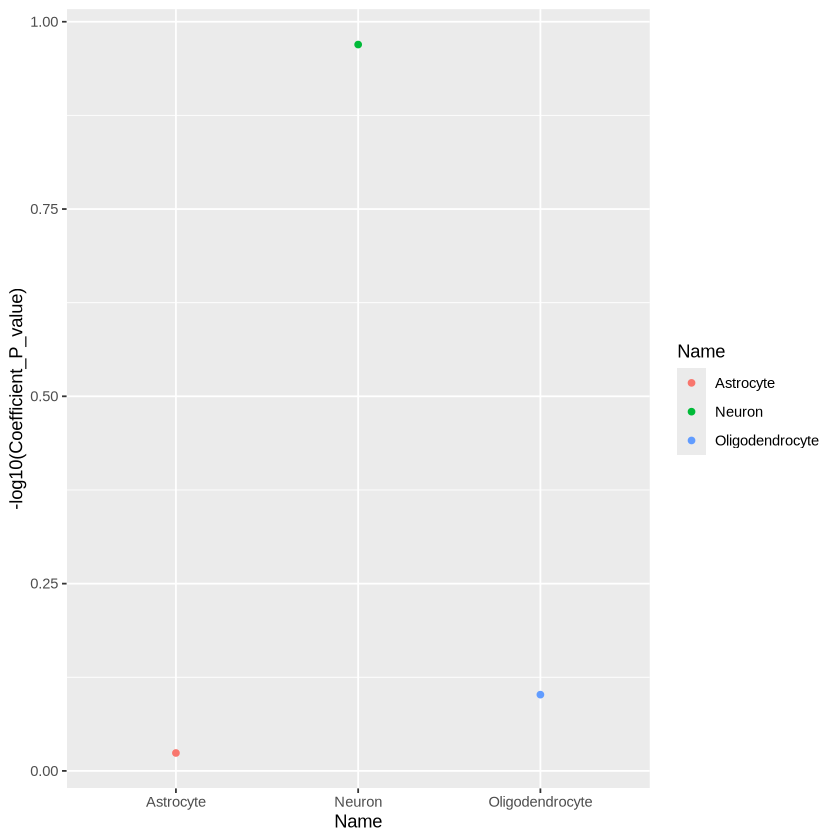

In [15]:
dir <- "output"

cts <- paste0(dir, '/BMI_Cahoy.cell_type_results.txt')

cts <- fread(cts)
cts
ggplot(data = cts, aes(x = Name, y = -log10(Coefficient_P_value))) + 
  geom_point(aes(color = Name))

## Assignment

Select a brain-related phenotype from this [list](https://nealelab.github.io/UKBB_ldsc/downloads.html#ldsc_sumstat_files) and download the pre-processed GWAS summary statistics. Run the following analysis:

  1. Partition heritability using the baseline model.\
  2. Estimating proportion of heritability explained by the three cell types above.\
  3. Run cell type-specific analysis using the Cahoy dataset.\
  4. Visualize results for analysis 1 - 3.